<a href="https://colab.research.google.com/github/gmihaila/stock_risk_prediction/blob/master/notebooks/train_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info

* Main Dataset: [S&P 500 stock data](https://www.kaggle.com/camnugent/sandp500)

* Download detailes for each company: [S&P 500 Companies with Financial Information](https://datahub.io/core/s-and-p-500-companies-financials#resource-s-and-p-500-companies-financials_zip)

Stock prices are flutuated in every day. So, in each day, put those stocks in order of price change to one sentence. Then, with certain window size, each stock will show up with highly related stock frequently, because they tend to move their prices together. Source: [stock2vec repo](https://github.com/kh-kim/stock2vec)

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.8.0
Num GPUs Available:  1


In [2]:
import gensim
import sys
print(sys.version)
print(gensim.__version__)

3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
4.1.2


In [3]:
# it works well in python 3.8 and gensim 4.1

# Imports

In [4]:
from gensim.models import Word2Vec, FastText, Doc2Vec
from gensim.test.utils import common_texts, get_tmpfile
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, Model, optimizers
from tensorflow.keras.layers import Bidirectional, LSTM, Embedding, RepeatVector, Dense
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from scipy.stats import zscore
from matplotlib.pyplot import figure

from numpy import mean
from numpy import absolute
from numpy import sqrt

import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
import operator

# Helper Functions

In [5]:
def sort_dict(mydict, reversed=False):
  return sorted(mydict.items(), key=operator.itemgetter(1), reverse=reversed)

# Read Data

In [6]:
# Companies description
desc_df = pd.read_csv('stocks_data//constituents.csv')
print('\nCompanies Details')
print(desc_df.head())

# stocks details
stocks_df = pd.read_csv('stocks_data//all_stocks_5yr.csv')#, parse_dates=['date'])
print('\nCompanies Stocks')
print(stocks_df.head())


Companies Details
  Symbol                 Name                  Sector
0    MMM           3M Company             Industrials
1    AOS      A.O. Smith Corp             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV          AbbVie Inc.             Health Care
4    ACN        Accenture plc  Information Technology

Companies Stocks
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL


# Preprocess

In [7]:
stocks_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [8]:
# dicitonary for companies name and sector
companies_names = {symbol:name for symbol, name in desc_df[['Symbol', 'Name']].values}
companies_sector = {symbol:sector for symbol, sector in desc_df[['Symbol', 'Sector']].values}

# get all companies symbols
symbols = stocks_df['Name'].values
dates = set(stocks_df['date'].values)
dates = sorted(dates)

# store each individual date and all its stocks
dates_dictionary = {date:{} for date in dates}

In [9]:
companies_sector

{'MMM': 'Industrials',
 'AOS': 'Industrials',
 'ABT': 'Health Care',
 'ABBV': 'Health Care',
 'ACN': 'Information Technology',
 'ATVI': 'Information Technology',
 'AYI': 'Industrials',
 'ADBE': 'Information Technology',
 'AAP': 'Consumer Discretionary',
 'AMD': 'Information Technology',
 'AES': 'Utilities',
 'AET': 'Health Care',
 'AMG': 'Financials',
 'AFL': 'Financials',
 'A': 'Health Care',
 'APD': 'Materials',
 'AKAM': 'Information Technology',
 'ALK': 'Industrials',
 'ALB': 'Materials',
 'ARE': 'Real Estate',
 'ALXN': 'Health Care',
 'ALGN': 'Health Care',
 'ALLE': 'Industrials',
 'AGN': 'Health Care',
 'ADS': 'Information Technology',
 'LNT': 'Utilities',
 'ALL': 'Financials',
 'GOOGL': 'Information Technology',
 'GOOG': 'Information Technology',
 'MO': 'Consumer Staples',
 'AMZN': 'Consumer Discretionary',
 'AEE': 'Utilities',
 'AAL': 'Industrials',
 'AEP': 'Utilities',
 'AXP': 'Financials',
 'AIG': 'Financials',
 'AMT': 'Real Estate',
 'AWK': 'Utilities',
 'AMP': 'Financials',


# Data for Word Embeddings

For each date in out dataset we rearrange each company in ascending order based on the **change in price**.

Formula for **change in price** [source](https://pocketsense.com/calculate-market-price-change-common-stock-4829.html):
* (closing_price - opening_price) / opening_price

We can change the formula to use highest price and lowest price. This is something we will test out.

In [10]:
# calculate price change for each stock and sort them in each day
for date, symbol, op, cl, in stocks_df[['date', 'Name', 'open', 'close']].values:
  # CHANGE IN PRICE: (closing_price - opening_price) / opening_price
  dates_dictionary[date][symbol] = (cl - op)/op
# sort each day reverse order
dates_dictionary = {date:sort_dict(dates_dictionary[date]) for date in dates}

stocks_w2v_data = [[value[0] for value in dates_dictionary[date]] for date in dates]

# print sample
print(stocks_w2v_data[0])

['MCO', 'MNST', 'SPGI', 'JNPR', 'AAL', 'BBY', 'INTU', 'SRCL', 'SCHW', 'MCHP', 'FLR', 'CL', 'ILMN', 'PVH', 'FB', 'M', 'IRM', 'VAR', 'DAL', 'BA', 'IT', 'BAC', 'EXC', 'ETR', 'XRX', 'O', 'LEN', 'LB', 'KLAC', 'PWR', 'RJF', 'HUM', 'C', 'VFC', 'EL', 'GLW', 'DHI', 'NEM', 'AEE', 'RMD', 'PG', 'RHT', 'RHI', 'MAS', 'EFX', 'DPS', 'IVZ', 'KSU', 'AES', 'NFLX', 'AXP', 'SIG', 'MU', 'TDG', 'RF', 'HIG', 'FDX', 'VZ', 'IDXX', 'PNC', 'T', 'LUK', 'ABBV', 'TRV', 'DVA', 'KMI', 'CTSH', 'CRM', 'FCX', 'ADM', 'PFE', 'CTAS', 'AMG', 'EQT', 'CCL', 'DGX', 'AKAM', 'NEE', 'GT', 'PEP', 'GPS', 'HCA', 'KO', 'NFX', 'COF', 'PDCO', 'BF.B', 'LEG', 'MET', 'SWK', 'NLSN', 'HRS', 'MDLZ', 'ARE', 'PEG', 'HP', 'CMS', 'ICE', 'DRI', 'MYL', 'SO', 'KMB', 'AJG', 'GRMN', 'DFS', 'BBT', 'CLX', 'PAYX', 'AFL', 'ETN', 'MKC', 'CSCO', 'NRG', 'ANSS', 'UAA', 'NI', 'KORS', 'K', 'TIF', 'UTX', 'BRK.B', 'DLR', 'F', 'GE', 'NVDA', 'NWL', 'EMR', 'A', 'ES', 'AIZ', 'PPL', 'NKE', 'JEC', 'AEP', 'DTE', 'SEE', 'ED', 'ABT', 'WY', 'HSIC', 'WU', 'PCG', 'RTN', 'QCO

In [11]:
# recreate model with 10 dimensions(this is the model that will be used for the rest of the code)
model = Word2Vec(stocks_w2v_data, min_count=1, vector_size=12,  window=50, negative=10)
words = list(model.wv.key_to_index.keys())
X = model.wv.vectors
Y = list()
for word in words:
    Y.append(companies_sector[word])



In [12]:
from sklearn.manifold import TSNE
tsne_wp_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=1500)
embeddings_wp_3d = tsne_wp_3d.fit_transform(X)

c:\users\jerry\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\users\jerry\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [188]:
# def plot_embedding(data):
#     x_min, x_max = np.min(data, 0), np.max(data, 0)
#     data = (data - x_min) / (x_max - x_min)
#     return data

In [190]:
# embeddings_wp_3d = plot_embedding(embeddings_wp_3d)

C:\Users\jerry\AppData\Local\Temp/ipykernel_11992/1285053670.py:12: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
C:\Users\jerry\AppData\Local\Temp/ipykernel_11992/1285053670.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(fname))


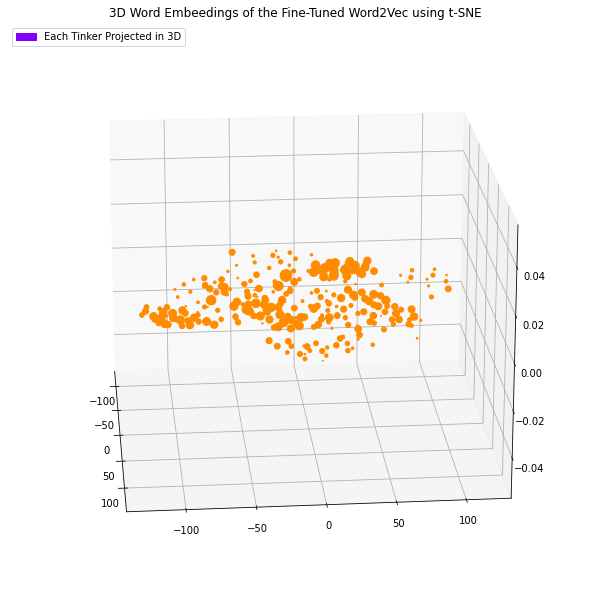

In [24]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import os
import tempfile
import imageio
import shutil

def tsne_plot_3d_gif(title, label, embeddings, filename, a):
    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
#     sector_color_dict = {'Industrials':'red','Health Care':'orange','Information Technology':'yellow','Utilities':'green',
#                      'Financials':'blue','Materials':'purple','Consumer Discretionary':'cyan','Real Estate':'magenta',
#                      'Consumer Staples':'pink','Energy':'brown','Telecommunication Services':'gray'}
#     cvec = [sector_color_dict[companies_sector[word]] for word in newWords]

    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c='darkorange', alpha=a)

    plt.title(title)

    red_patch = mpatches.Patch(color=colors[0], label=label)
    plt.legend(handles=[red_patch], loc=2)

    dirpath = tempfile.mkdtemp()
    images = []
    for angle in range(0, 720, 5):
        ax.view_init(20, angle)
        fname = os.path.join(dirpath, str(angle) + '.png')
        plt.savefig(fname, dpi=120, format='png', bbox_inches='tight')
        images.append(imageio.imread(fname))
    imageio.mimsave('3d.gif', images)
    shutil.rmtree(dirpath)


tsne_plot_3d_gif('3D Word Embeedings of the Fine-Tuned Word2Vec using t-SNE', 'Each Tinker Projected in 3D',
                                  embeddings_wp_3d, '3d.gif', 1)

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [170]:
from sklearn.datasets import load_digits
a = load_digits()

c:\users\jerry\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jerry\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jerry\AppData\Local\Temp/ipykernel_20832/3664608671.py:21: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


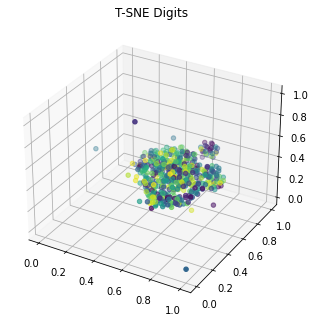

In [41]:
# 将坐标缩放到[0,1]区间  
def plot_embedding(data):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    return data


def t_sne(n_components):
    if n_components == 2:
        tsne_digits = TSNE(n_components=n_components, random_state=35).fit_transform(digits.data)
        aim_data = plot_embedding(tsne_digits)
        plt.figure()
        plt.subplot(111)
        plt.scatter(aim_data[:, 0], aim_data[:, 1], c=range(len(X)))
        plt.title("T-SNE Digits")
        plt.savefig("T-SNE_Digits.png")
    elif n_components == 3:
        tsne_digits = TSNE(n_components=n_components, random_state=35).fit_transform(digits.data)
        aim_data = plot_embedding(tsne_digits)
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(aim_data[:, 0], aim_data[:, 1], aim_data[:, 2], c=range(len(X)))
        plt.title("T-SNE Digits")
        plt.savefig("T-SNE_Digits_3d.png")
    else:
        print("The value of n_components can only be 2 or 3")

    plt.show()


def main():
    t_sne(3)


if __name__ == '__main__':
    main()